In [1]:
import os
os.chdir("../")
os.getcwd()

'/home/Aishu/dl-model-extraction'

In [2]:
from attacker.query import *
from attacker.utils import *
from victim import *
from victim.interface import  fetch_victim_model

set_seed(42)

# Query victim model & Train attacker model

In [ ]:
# logits
k = 3

# get dataset in dataloader
trainloader, testloader, outputs = get_dataloader(config["victim"]["data"])

# query & save test data with labels
querytestloader = query_victim(config["victim"], outputs, testloader, len(testloader.dataset), train=False)

# sample train data on querytype.size
sampledtrainloader = query_type(config["victim"], outputs, trainloader, config["query_size"],
                                f'queried/query_traindata_{config["victim"]["data"]}_{config["victim"]["model_name"]}_k{k}',
                                config["query_type"])

# fetch victim
victim_model = fetch_victim_model(args=config["victim"])

# initialize attacker model
attacker = get_model(config["attacker"], outputs)

# train attacker model
attacker_result = attacker_training_w_logits(victim_model, attacker, sampledtrainloader, querytestloader, k)

# save & visualize model inference
title = f'Trial-A_{config["attacker"]}_{config["victim"]["model_name"]}_{config["victim"]["data"]}{config["query_type"]}_{config["query_size"]}'
percent = save_visualize(attacker, attacker_result,title )
results_dict={"Victim":config["victim"]["model_name"],
                "Dataset":config["victim"]["data"],
                "QueryType": config["query_type"],
                "QuerySize": config["query_size"],
                "Queried Output": k ,
                "Attacker": config["attacker"],
                "Train Loss": percent[0],
                "Train Accuracy": percent[1],
                "Test Loss": percent[2],
                "Test Accuracy": percent[3]}
print(results_dict)

# Parameters

In [3]:
parameters = {
        "query_size": [20000],
        "query_type": ['coreset'],
        "victim":[{ "data": CIFAR_10, "model_name": RESNET50}],
        "attacker":[RESNET34],
        "k-logits": [3, 10]
}

# Special Investigations

K-Logits

config={'batch_size': 500, 'learning_rate': 0.008, 'lr_cycles': 2, 'lr_steps': 1000, 'base_lr': 1e-05, 'max_lr': 0.1, 'query_size': 20000, 'query_type': 'coreset', 'victim': {'data': 'cifar_10', 'model_name': 'resnet50'}, 'attacker': 'resnet34'}

parameters={'query_size': [20000], 'query_type': ['coreset'], 'victim': [{'data': 'cifar_10', 'model_name': 'resnet50'}], 'attacker': ['resnet34'], 'k-logits': [3, 10]}

---------------------------------------------------------------------------
Files already downloaded and verified
Files already downloaded and verified
Loading queried cifar_10 dataset with resnet50 victim
    - input:10000 queried:10000
Sample using None with query size 10000
    - input:10000 sampled:10000 data augmentation:False
-----------------------------------------------------------------------------
-----------------------Dataset: cifar_10----------------------------
--------Victim: resnet50 Attacker: resnet34------------
---------------Query Type: coreset Query Size:

    - test_acc  0.22770 test_loss  3.68406
epoch 76
    - train_acc 0.71605 train_loss 0.87089
    - test_acc  0.10730 test_loss  4.12396
epoch 77
    - train_acc 0.72400 train_loss 0.88595
    - test_acc  0.15290 test_loss  4.12002
epoch 78
    - train_acc 0.72830 train_loss 0.76791
    - test_acc  0.21430 test_loss  3.47275
epoch 79
    - train_acc 0.73155 train_loss 0.80668
    - test_acc  0.35120 test_loss  3.09562
epoch 80
    - train_acc 0.74305 train_loss 0.87692
    - test_acc  0.12320 test_loss  4.41756
epoch 81
    - train_acc 0.74675 train_loss 0.84072
    - test_acc  0.35540 test_loss  3.21207
epoch 82
    - train_acc 0.75035 train_loss 0.83955
    - test_acc  0.22710 test_loss  4.01959
epoch 83
    - train_acc 0.75240 train_loss 0.84714
    - test_acc  0.25020 test_loss  3.98420
epoch 84
    - train_acc 0.77150 train_loss 0.81378
    - test_acc  0.17390 test_loss  4.44087
epoch 85
    - train_acc 0.77925 train_loss 0.81450
    - test_acc  0.21100 test_loss  4.33319
epoch 8

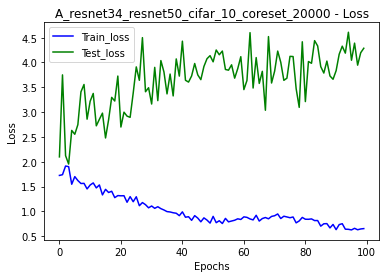

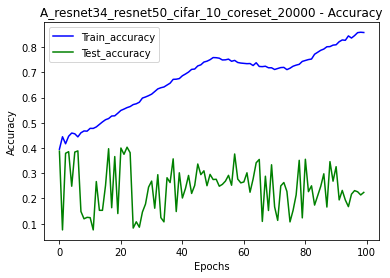

{'Victim': 'resnet50', 'Dataset': 'cifar_10', 'QueryType': 'coreset', 'QuerySize': 20000, 'Queried Output': 3, 'Attacker': 'resnet34', 'Train Loss': 0.6518, 'Train Accuracy': 85.75, 'Test Loss': 4.2871, 'Test Accuracy': 22.41}
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------Dataset: cifar_10----------------------------
--------Victim: resnet50 Attacker: resnet34------------
---------------Query Type: coreset Query Size: 20000-------------------
Sample using coreset with query size 20000
    - input:50000 sampled:20000 data augmentation:None
Total epochs: 100
epoch 1
    - train_acc 0.39975 train_loss 1.83689
    - test_acc  0.40720 test_loss  1.92728
epoch 2
    - train_acc 0.43320 train_loss 2.24870
    - test_acc  0.37550 test_loss  68.96926
epoch 3
    - train_acc 0.41845 train_loss 2.09365
    - test_acc  0.18310 test_loss  109.68678
epoch 4
    - train

In [ ]:
print(f'config={config}\n\nparameters={parameters}\n')
Results = []
# Iterate through Victim Model & Dataset
for victim in parameters["victim"]:
    print('---------------------------------------------------------------------------')
    # get dataset in dataloader
    trainloader, testloader, outputs = get_dataloader(victim["data"])

    # query test data
    querytestloader = query_victim(victim, outputs, testloader, len(testloader.dataset), train=False)

    # Iterate through Attacker Model
    for attacker_type in parameters["attacker"]:
        # Iterate Through Query Type
        for querytype in parameters["query_type"]:
            # Iterate Through Query Size
            for size in parameters["query_size"]:
                # Iterate Through Logits size
                for k in parameters["k-logits"]:
                    print('-----------------------------------------------------------------------------')
                    print(f'-----------------------Dataset: {victim["data"]}----------------------------')
                    print(f'--------Victim: {victim["model_name"]} Attacker: {attacker_type}------------')
                    print(f'---------------Query Type: {querytype} Query Size: {size}-------------------')

                    # sample train data on querytype.size
                    sampledtrainloader = query_type(victim, outputs, trainloader, size,
                                    f'queried/query_traindata_{victim["data"]}_{victim["model_name"]}_k{k}', querytype)

                    # fetch victim
                    victim_model = fetch_victim_model(args=victim)

                    # initialize attacker model
                    attacker = get_model(attacker_type, outputs)

                    # train attacker model
                    attacker_result = attacker_training_w_logits(victim_model, attacker, sampledtrainloader, querytestloader, k)

                    # save & visualize model inference
                    title = f'A_{attacker_type}_{victim["model_name"]}_{victim["data"]}_{querytype}_{size}'
                    percent = save_visualize(attacker, attacker_result,title )
                    results_dict={"Victim":victim["model_name"],
                                    "Dataset":victim["data"],
                                    "QueryType": querytype,
                                    "QuerySize": size,
                                    "Queried Output": k,
                                    "Attacker": attacker_type,
                                    "Train Loss": percent[0],
                                    "Train Accuracy": percent[1],
                                    "Test Loss": percent[2],
                                    "Test Accuracy": percent[3]}

                    print(results_dict)
                    Results.append(results_dict)
                    print('-----------------------------------------------------------------------------')

In [ ]:
Results